Model is not converging.  Current: -39667.40864521873 is not greater than 27420.399946490827. Delta is -67087.80859170956


Train shapes: (22042, 60, 11)
Test shapes: (22042, 10)
689/689 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step
Model 1 - RMSE: 16.88054656982422, MSE: 284.952880859375
689/689 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step
Model 2 - RMSE: 35.75919723510742, MSE: 1278.72021484375
689/689 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step
Model 3 - RMSE: 32.974117279052734, MSE: 1087.2923583984375
689/689 ━━━━━━━━━━━━━━━━━━━━ 55s 78ms/step
Model 4 - RMSE: 81.68407440185547, MSE: 6672.28759765625
Best performing model: best_model.keras with RMSE: 16.88054656982422


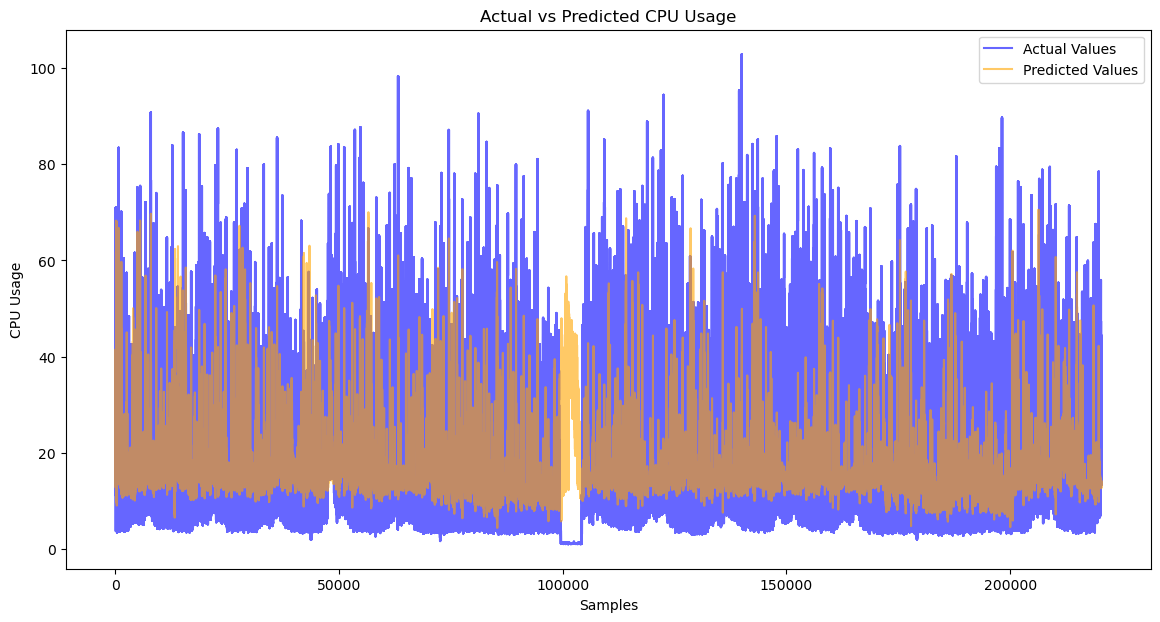

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.regularizers import *
from keras.optimizers import *
from tensorflow import keras
from sklearn.metrics import *
from datetime import datetime, timedelta
from sklearn.model_selection import *
from scipy import interpolate
import json
from pathlib import Path
from pandas import to_numeric
from hmmlearn import hmm
from keras.losses import *
from dateutil import parser

def create_time_features(data):
    # Assume 'cpu_data' is your dataframe and 'datetime' is the column with datetime values
    data['datetime'] = pd.to_datetime(data['datetime'])  # Ensure it's a datetime type
    data['hour'] = data['datetime'].dt.hour
    data['day_of_week'] = data['datetime'].dt.dayofweek
    data['month'] = data['datetime'].dt.month
    data['day_of_month'] = data['datetime'].dt.day
    data['is_weekend'] = data['datetime'].dt.weekday >= 5  # True for Saturday and Sunday
    return data

# Define a function to create lagged features
def create_additional_features(df, target_col, lags):
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    df['cpu_change'] = df['cpu_usage'].diff() # Change in CPU usage
    df['moving_avg'] = df['cpu_usage'].rolling(window=10).mean() # 10-minute moving average
    return df

cpu_data = pd.read_csv('../Utilities\csv/cpu_usage_data_test.csv')
# Convert 'datetime' column to datetime objects
cpu_data['datetime'] = pd.to_datetime(cpu_data['datetime'])

# Set 'datetime' as the index
cpu_data.set_index('datetime', inplace=True)

# Resample to 1-minute intervals and interpolate
cpu_data = cpu_data.resample('1T').interpolate(method='linear')
cpu_data.reset_index(inplace=True)
if 'machine_id' in cpu_data.columns:
    cpu_data['machine_id'] = pd.Categorical(cpu_data['machine_id']).codes + 1
else:
    cpu_data['machine_id'] = 1
cpu_data = create_time_features(cpu_data)
lags = [5, 10, 60]
cpu_data = create_additional_features(cpu_data, 'cpu_usage', lags)

# Drop any rows with NaN values that were created due to shifting
cpu_data.dropna(inplace=True)

column_to_move = cpu_data.pop('cpu_usage')
cpu_data.insert(1, 'cpu_usage', column_to_move)
all_features_no_timestamp = cpu_data.columns[1:len(cpu_data.columns)]
# Extract the relevant features from your dataset for the HMM
features_for_hmm = cpu_data[all_features_no_timestamp].values

# Define and fit the HMM model
num_states = 10  # You can adjust this based on the nature of the data
model = hmm.GaussianHMM(n_components=num_states, covariance_type="full", n_iter=1000)

# Fit the HMM model to the features
model.fit(features_for_hmm)

# Predict hidden states for each time step
hidden_states = model.predict(features_for_hmm)

cpu_data['hidden_state'] = hidden_states

cpu_data.head

# Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Window size (e.g., past 60 time steps) and prediction horizon (next 10 timesteps)
window_size = 60
prediction_horizon = 10

# Function to generate LSTM sequences
def create_lstm_sequences(group_data, window_size, prediction_horizon):
    X, y = [], []
    for i in range(len(group_data) - window_size - prediction_horizon + 1):
        # Features are all columns except 'datetime', 'cpu_usage', and 'machine_id'
        X.append(group_data.iloc[i:i + window_size].drop(columns=['datetime', 'cpu_usage', 'machine_id']).values)
        # Target is the next 10 CPU usage values
        y.append(group_data.iloc[i + window_size:i + window_size + prediction_horizon]['cpu_usage'].values)
    return np.array(X), np.array(y)

all_features_no_timestamp_cpu_usage = cpu_data.columns[2:len(cpu_data.columns)]
# Scale features and target (fit on the entire dataset)
cpu_data[all_features_no_timestamp_cpu_usage] = feature_scaler.fit_transform(cpu_data[all_features_no_timestamp_cpu_usage])
cpu_data[["cpu_usage"]] = target_scaler.fit_transform(cpu_data[["cpu_usage"]])

X_test, y_test = create_lstm_sequences(cpu_data, window_size, prediction_horizon)

# Print the shapes of the final train/test data
print("Train shapes:", X_test.shape)
print("Test shapes:", y_test.shape)

# Define paths to the models
model_paths = [
    'best_model.keras',
    'best_model_idea.keras',
    'best_model_2.keras',
    'best_model_colab.keras'
]

# Create a dictionary to store model performances
model_performance = {}

# Loop over each model
for i, model_path in enumerate(model_paths):
    # Load the model
    model = load_model(model_path)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Inverse transform predictions and actual values if necessary
    y_pred_unscaled = target_scaler.inverse_transform(y_pred)
    y_test_unscaled = target_scaler.inverse_transform(y_test)
    
    # Calculate MSE and RMSE
    mse = mean_squared_error(y_test_unscaled.flatten(), y_pred_unscaled.flatten())
    rmse = np.sqrt(mse)
    
    # Store the results
    model_performance[f'model_{i+1}'] = {'MSE': mse, 'RMSE': rmse, 'Name': model_path, 'predictions': y_pred_unscaled.flatten() ,'true': y_test_unscaled.flatten()}

    # Print or log performance for this model
    print(f"Model {i+1} - RMSE: {rmse}, MSE: {mse}")

# Optionally, you can find the best performing model
best_model = min(model_performance, key=lambda x: model_performance[x]['RMSE'])
print(f"Best performing model: {model_performance[best_model]['Name']} with RMSE: {model_performance[best_model]['RMSE']}")
plt.figure(figsize=(14, 7))
plt.plot(model_performance[best_model]['true'], label='Actual Values', color='blue', alpha=0.6)
plt.plot(model_performance[best_model]['predictions'], label='Predicted Values', color='orange', alpha=0.6)
plt.title('Actual vs Predicted CPU Usage')
plt.xlabel('Samples')
plt.ylabel('CPU Usage')
plt.legend()
plt.show()

# BEST_MODEL_IDEA

In [7]:
# Load your data
cpu_data = pd.read_csv('../Utilities/csv/cpu_usage_train.csv')

# Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Window size (e.g., past 60 time steps) and prediction horizon (next 10 timesteps)
window_size = 60
prediction_horizon = 10

# Function to generate LSTM sequences
def create_lstm_sequences(group_data, window_size, prediction_horizon):
    X, y = [], []
    for i in range(len(group_data) - window_size - prediction_horizon + 1):
        # Features are all columns except 'datetime', 'cpu_usage', and 'machine_id'
        X.append(group_data.iloc[i:i + window_size].drop(columns=['datetime', 'cpu_usage', 'machine_id']).values)
        # Target is the next 10 CPU usage values
        y.append(group_data.iloc[i + window_size:i + window_size + prediction_horizon]['cpu_usage'].values)
    return np.array(X), np.array(y)

all_features_no_timestamp_cpu_usage = cpu_data.columns[2:len(cpu_data.columns)]
# Scale features and target (fit on the entire dataset)
cpu_data[all_features_no_timestamp_cpu_usage] = feature_scaler.fit_transform(cpu_data[all_features_no_timestamp_cpu_usage])
cpu_data[["cpu_usage"]] = target_scaler.fit_transform(cpu_data[["cpu_usage"]])

# Train/test split ratios
train_ratio = 0.8

# Lists to store train/test data
X_train_all, y_train_all = [], []
X_test_all, y_test_all = [], []

# Group by machine_id
for machine_id, group_data in cpu_data.groupby('machine_id'):
    # Split the data into train and test sets for this machine
    train_data, test_data = train_test_split(group_data, test_size=1 - train_ratio, shuffle=False)
    
    # Generate moving windows for the training set
    X_train, y_train = create_lstm_sequences(train_data, window_size, prediction_horizon)
    X_train_all.append(X_train)
    y_train_all.append(y_train)
    
    # Generate moving windows for the test set
    X_test, y_test = create_lstm_sequences(test_data, window_size, prediction_horizon)
    X_test_all.append(X_test)
    y_test_all.append(y_test)

# Combine all the machine-specific windows together for training and testing
X_train_all = np.concatenate(X_train_all, axis=0)
y_train_all = np.concatenate(y_train_all, axis=0)
X_test_all = np.concatenate(X_test_all, axis=0)
y_test_all = np.concatenate(y_test_all, axis=0)

# Print the shapes of the final train/test data
print("Train shapes:", X_train_all.shape, y_train_all.shape)
print("Test shapes:", X_test_all.shape, y_test_all.shape)

# Build the enhanced CNN-LSTM model
lstm_model = Sequential()
lstm_model.add(Input(shape=(X_train_all.shape[1], X_train_all.shape[2])))
# CNN layers
lstm_model.add(Conv1D(filters=125, kernel_size=3, activation='relu'))
lstm_model.add(BatchNormalization())  # Normalize activations
lstm_model.add(Conv1D(filters=75, kernel_size=3, activation='relu'))
lstm_model.add(BatchNormalization())  # Normalize activations
lstm_model.add(MaxPooling1D(pool_size=2))
# LSTM layers
lstm_model.add(LSTM(units=175, return_sequences=True))
lstm_model.add(Dropout(0.4))
lstm_model.add(LSTM(units=100, return_sequences=True))
lstm_model.add(Dropout(0.4))
lstm_model.add(LSTM(units=50, return_sequences=False))
# Output layer (multi-step prediction)
lstm_model.add(Dense(prediction_horizon))

# Early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_idea.keras', monitor='val_loss', save_best_only=True, mode='min')
# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
lstm_model.compile(optimizer="adam", loss=Huber())  # Use Huber loss to reduce outliers' impact
lstm_model.summary()
# Train the model
history = lstm_model.fit(X_train_all, y_train_all, epochs=50, batch_size=64, validation_data=(X_test_all, y_test_all),
                         verbose=1, callbacks=[early_stopping, model_checkpoint, reduce_lr])

mse_lstm = lstm_model.evaluate(X_test_all, y_test_all)
rmse_lstm = np.sqrt(mse_lstm)

print(f"RMSE: {rmse_lstm}, MSE: {mse_lstm}")

Train shapes: (160742, 60, 11) (160742, 10)
Test shapes: (39825, 60, 11) (39825, 10)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 58, 125)        │         4,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 58, 125)        │           500 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 56, 75)         │        28,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 56, 75)         │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 28, 75)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 28, 175)        │       175,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 175)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 28, 100)        │       110,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 28, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 350,060 (1.34 MB)

 Trainable params: 349,660 (1.33 MB)

 Non-trainable params: 400 (1.56 KB)

Epoch 1/50
2512/2512 ━━━━━━━━━━━━━━━━━━━━ 326s 127ms/step - loss: 0.0041 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 2/50
2512/2512 ━━━━━━━━━━━━━━━━━━━━ 347s 138ms/step - loss: 0.0021 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 3/50
2512/2512 ━━━━━━━━━━━━━━━━━━━━ 388s 140ms/step - loss: 0.0018 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 4/50
2512/2512 ━━━━━━━━━━━━━━━━━━━━ 409s 163ms/step - loss: 0.0017 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 5/50
2512/2512 ━━━━━━━━━━━━━━━━━━━━ 383s 153ms/step - loss: 0.0016 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 6/50
2512/2512 ━━━━━━━━━━━━━━━━━━━━ 374s 149ms/step - loss: 0.0015 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 7/50
2512/2512 ━━━━━━━━━━━━━━━━━━━━ 345s 137ms/step - loss: 0.0014 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 8/50
2512/2512 ━━━━━━━━━━━━━━━━━━━━ 377s 135ms/step - loss: 0.0013 - val_loss: 0.0015 - learning_rate: 5.0000e-04
Epoch 9/50
2512/2512 ━━━━━━━━━━━━━━━━━━━━ 383s 135ms/step - loss: 0.